In [1]:
path_to_rgb = "./Sequence_2/rgb"
path_to_depth = "./Sequence_2/depth"
path_to_camera_param = "./Sequence_2/traj_w_c.txt"

In [2]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import cv2
import os

(480, 640, 3)


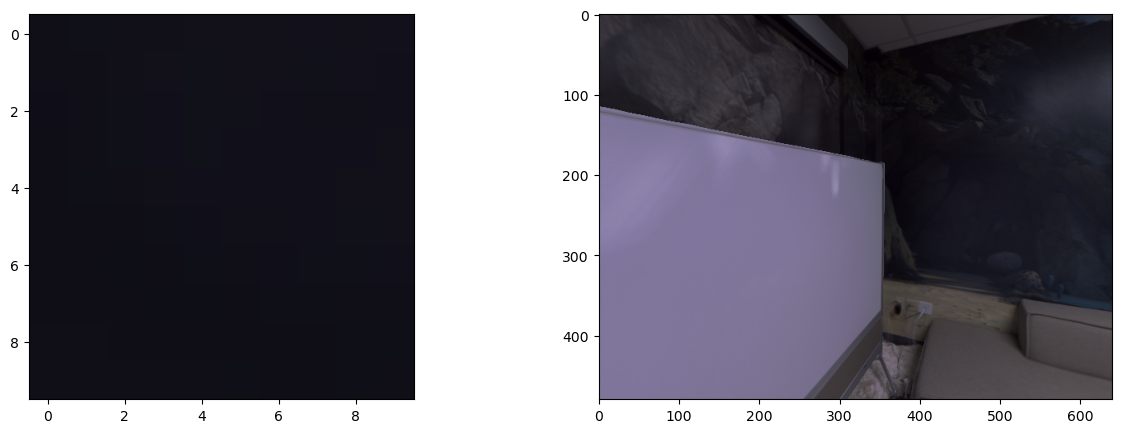

In [3]:
# Load images
img1 = cv2.cvtColor(cv2.imread(os.path.join(path_to_rgb, "rgb_0.png")), cv2.COLOR_BGR2RGB)
print(img1.shape)
# Let's visualize the images
f = plt.figure(figsize=(15, 5))
ax1 = f.add_subplot(121)
ax2 = f.add_subplot(122)
ax1.imshow(img1[300:310, 400:410, :])
ax2.imshow(img1)
plt.show()

(480, 640)
717


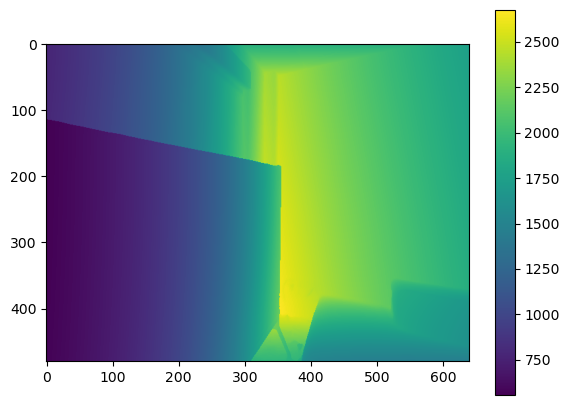

In [4]:
img2 = cv2.imread(os.path.join(path_to_depth, "depth_0.png"), cv2.IMREAD_UNCHANGED) # rgb channels has same value
print(img2.shape)
print(img2[400, 100])
# Let's visualize the images
f = plt.figure(figsize=(15, 5))
ax1 = f.add_subplot(121)
im = ax1.imshow(img2)
plt.colorbar(im, ax=ax1)
plt.show()

In [5]:
def imageto3dpoints (rgb_im, depth_im, ctw_mat):
    z_c = (depth_im.flatten())/1000 # 1 for image plane (z = 1) /1000 for units to be meters
    w_c = np.ones(z_c.shape)
    x, y, _ = rgb_im.shape
    # cx, cy = x//2, y//2 
    x_c= np.arange(x)
    y_c = np.arange(y)
    x_c, y_c = np.meshgrid(x_c, y_c, indexing='ij')
    x_c, y_c = x_c.flatten(), y_c.flatten()
    X = np.stack([(y_c)*z_c/3, (x_c)*z_c/3, z_c, w_c], axis=0) # assuming pixel size to be 0.26mm and consider reverting translation by (cx, cy)
    X_ = ctw_mat @ X

    origin = np.array([0,0,0,1])
    x_axis = np.array([1/1000,0,0,1])
    y_axis = np.array([0,1/1000,0,1])
    z_axis= np.array([0,0,1/1000,1])
    camera = ctw_mat @ np.stack([origin, x_axis, y_axis, z_axis], axis=-1)

    colors = rgb_im.reshape((-1, 3))/255
    return X_.T, colors, camera.T

In [6]:
origin = np.array([0,0,0,1])
x_axis = np.array([1,0,0,1])
y_axis = np.array([0,1,0,1])
z_axis= np.array([0,0,1,1])
np.stack([origin, x_axis, y_axis, z_axis], axis=-1)

array([[0, 1, 0, 0],
       [0, 0, 1, 0],
       [0, 0, 0, 1],
       [1, 1, 1, 1]])

In [7]:
class camera_mat:
    def __init__ (self, path):
        self.path = path
        self.mats = []
        # self.cursor : later
        with open(path, "r") as f:
            while True:
                line = f.readline()
                if not line: break
                self.mats.append(self.str_to_44mat(line))
    def __getitem__ (self, idx):
        return self.mats[idx]
    @staticmethod
    def str_to_44mat (s):
        mat = np.array(list(map(float, s.split()))).reshape((4, 4))
        return mat

matrices = camera_mat(path_to_camera_param)
mat_0 = matrices[0]
print(mat_0)

[[-0.52112179  0.07730852 -0.84997381  0.79893329]
 [ 0.85348233  0.04720327 -0.51897955 -1.90775605]
 [ 0.         -0.99588917 -0.09058011  0.48820354]
 [ 0.          0.          0.          1.        ]]


: 

In [8]:
# Draw results
%matplotlib widget
fig = plt.figure(figsize=(5,5))
ax2 = fig.add_subplot(111, projection='3d')

def show_multiple (n):
    for i in range(n):
        rgb_fname = "rgb_" + str(i) + ".png"
        rgb_im = cv2.cvtColor(cv2.imread(os.path.join(path_to_rgb, rgb_fname)), cv2.COLOR_BGR2RGB)
        depth_fname = "depth_" + str(i) + ".png"
        depth_im = cv2.imread(os.path.join(path_to_depth, depth_fname), cv2.IMREAD_UNCHANGED) # rgb channels has same value
        ctw_mat = matrices[i]
        X_, colors, camera_axis = imageto3dpoints(rgb_im, depth_im, ctw_mat)
        ax2.scatter(
            X_[:, 0], # x
            X_[:, 2], # z
            X_[:, 1], # y
            c=colors, marker='o', s=0.0001
        )
        ax2.plot( # lines by x, z, y 
            [camera_axis[0][0], camera_axis[1][0]], [camera_axis[0][2], camera_axis[1][2]],  [-camera_axis[0][1], -camera_axis[1][1]], c='r'
        )
        ax2.plot(
            [camera_axis[0][0], camera_axis[2][0]], [camera_axis[0][2], camera_axis[2][2]], [-camera_axis[0][1], -camera_axis[2][1]], c='b'
        )
        ax2.plot(
            [camera_axis[0][0], camera_axis[3][0]], [camera_axis[0][2], camera_axis[3][2]], [-camera_axis[0][1], -camera_axis[3][1]], c='g'
        )
   
show_multiple(10)
ax2.set_xlabel('X Axis')
ax2.set_ylabel('Z Axis')
ax2.set_zlabel('Y Axis')
plt.show()